<a href="https://colab.research.google.com/github/willw625731/Deep-Learning-Notebooks/blob/master/Omniglot_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from PIL import Image

import torchvision
import torchvision.transforms as transforms

import os
import random

%matplotlib inline

In [ ]:
# Import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract data

#!mkdir 'drive/My Drive/challenge'
#!ls 'drive/My Drive/challenge/omniglot/data'
#!mkdir 'drive/My Drive/challenge/omniglot/data/background'
#!mkdir 'drive/My Drive/challenge/omniglot/data/evaluation'
#!unzip -q 'drive/My Drive/challenge/omniglot/data/images_background.zip' -d 'drive/My Drive/challenge/omniglot/data/background'
#!unzip -q 'drive/My Drive/challenge/omniglot/data/images_evaluation.zip' -d 'drive/My Drive/challenge/omniglot/data/evaluation'

In [ ]:
# Setup folders for saving models
#!mkdir 'drive/My Drive/challenge/omniglot'
#!cp -r models/* 'drive/My Drive/challenge/omniglot/models/'

In [ ]:
train_path = 'drive/My Drive/challenge/omniglot/data/background/images_background'
test_path = 'drive/My Drive/challenge/omniglot/data/evaluation/images_evaluation'

train_paths = {}
test_paths = {}

for lang in os.listdir(train_path):
    train_paths[lang] = {}
    for char in os.listdir(os.path.join(train_path, lang)):
        train_paths[lang][char] = os.listdir(os.path.join(train_path, lang, char))

for lang in os.listdir(test_path):
    test_paths[lang] = {}
    for char in os.listdir(os.path.join(test_path, lang)):
        test_paths[lang][char] = os.listdir(os.path.join(test_path, lang, char))

In [ ]:
print(random.choice(list(train_paths.keys())))
print(random.choice(list(train_paths[random.choice(list(train_paths.keys()))])))

Ojibwe_(Canadian_Aboriginal_Syllabics)
character07


In [ ]:
# Load Omniglot dataset

dataset = torchvision.datasets.Omniglot(
    root="./data", background=True, download=True, 
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Lambda(lambda x:1-x)])
)

evalset = torchvision.datasets.Omniglot(
    root="./data", background=False, download=True, 
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Lambda(lambda x:1-x)])
)

image, label = dataset[0]
dataset_len = len(dataset)
print(type(image))  # torch.Tensor
print(type(label))  # int
print(dataset_len)
print(dataset[-1][1]) # Last label, 964 character classes, 20 symbols per character

Files already downloaded and verified


Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py
<class 'torch.Tensor'>
<class 'int'>
19280
963


A bit filp is performed on the input images to switch the empty canvas from a value of 1 to 0. This may be arbitrary but intuition suggests that this will better direct the network attention to learning the symbol representation rather than the negative space.

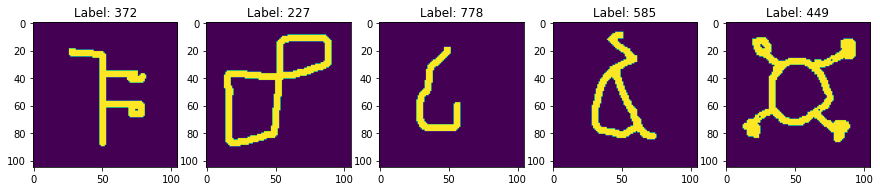

In [ ]:
# Explore dataset
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[15,3])

for i in range(5):
    img_index = np.random.randint(0, len(dataset))
    img, label = dataset[img_index]
    axs[i].imshow(img.squeeze())
    axs[i].set_title("Label: {}".format(label))

Syriac_(Estrangelo)
23
Futurama
26
Grantha
43
Greek
24
Gujarati
48
Hebrew
22
Japanese_(hiragana)
52
Inuktitut_(Canadian_Aboriginal_Syllabics)
16
Malay_(Jawi_-_Arabic)
40
Japanese_(katakana)
47
Korean
40
Latin
26
Mkhedruli_(Georgian)
41
N_Ko
33
Ojibwe_(Canadian_Aboriginal_Syllabics)
14
Sanskrit
42
Tagalog
17
Tifinagh
55
Alphabet_of_the_Magi
20
Anglo-Saxon_Futhorc
29
Arcadian
26
Armenian
41
Asomtavruli_(Georgian)
40
Balinese
24
Bengali
46
Blackfoot_(Canadian_Aboriginal_Syllabics)
14
Braille
26
Burmese_(Myanmar)
34
Cyrillic
33
Early_Aramaic
22


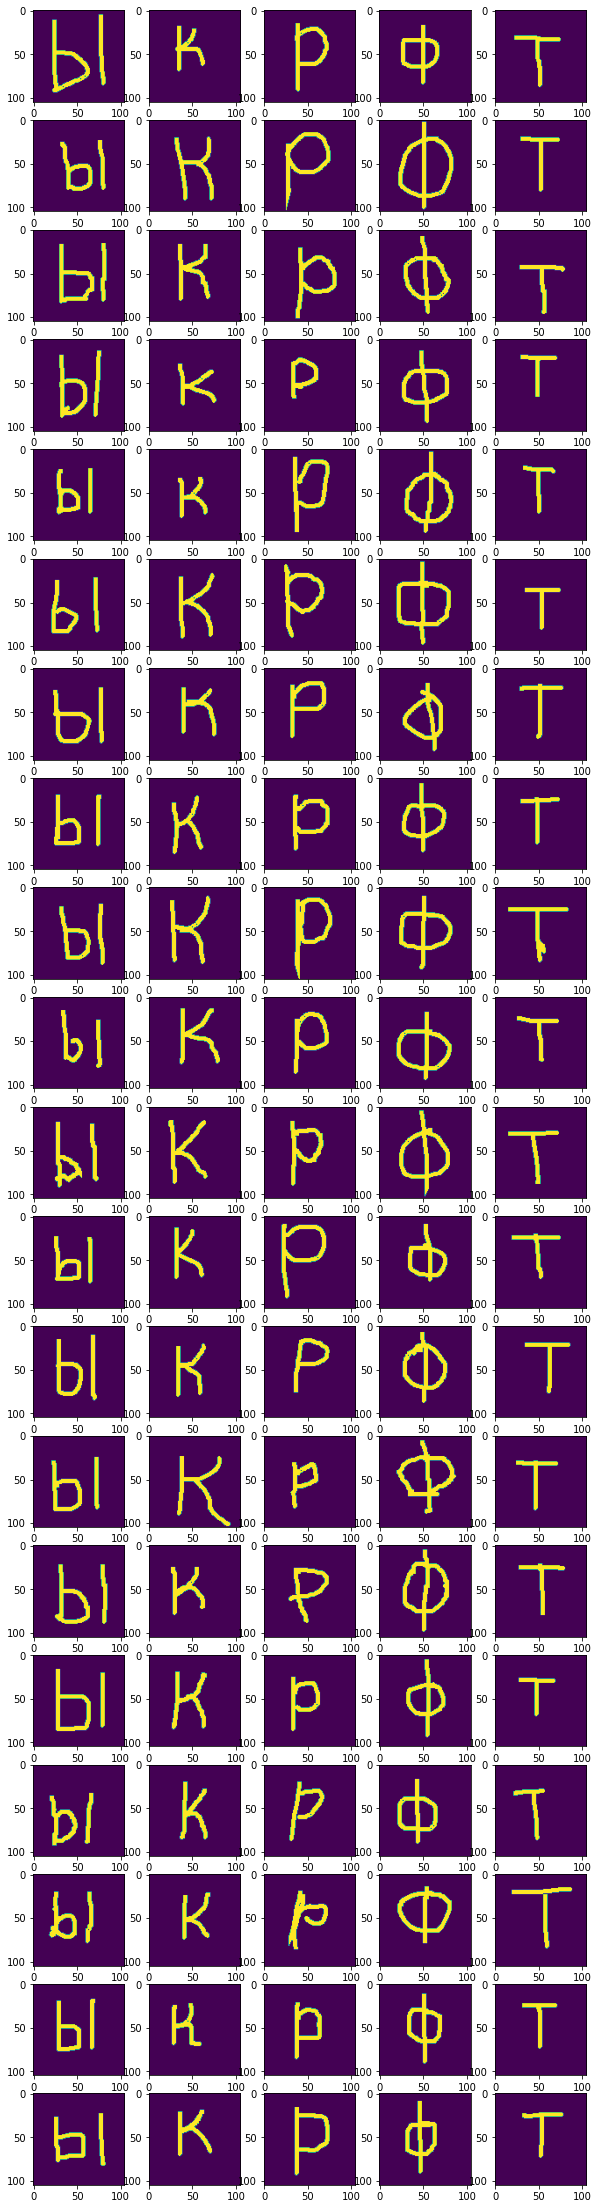

In [ ]:
train_lang_dex = {}
count = 0
count_dummy = 0
for lang in train_paths.keys():
    print(lang)
    print(len(train_paths[lang].keys()))
    count_dummy += len(train_paths[lang].keys())
    train_lang_dex[lang] = (len(train_paths[lang].keys()), count, count_dummy)
    count = count_dummy

fig, ax = plt.subplots(nrows=20, ncols=5, figsize=[10,40])
for i in range(20):
    for j in range(5):
        ax[i,j].imshow(dataset[(296+j)*20+i][0].squeeze())

**Task: One shot learning of alphabet charater images**

1. Comparing two images the model should classify if the images represent the same charater.
2. Model must therefore recognise structure and ignore affine transformations.
3. Test set will be unseen before recognition task.

Ideas:
* Train Variational autoencoder to reproduce images.
* Use learned latent representation for similarity measure.
* Fine tune on classification task (alphabet/character level). 
* One-shot learning with vector similarity on latent representation.

Further work:
* DenseNet/Optimised architecture
* Simultaneous traning
* Fully convolutional network vs Fully connected core comparison






In [ ]:
# CUDA setup

device = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

torch.cuda.is_available()

True

In [ ]:
# Model definition

class reparameterisation_layer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class encoder(nn.Module):
    def __init__(self, latent_dim, filters=[1, 16, 32, 64]):
        super().__init__()
        self.c1 = nn.Conv2d(filters[0], filters[1], 3, stride=2)
        self.c2 = nn.Conv2d(filters[1], filters[2], 5, stride=2)
        self.c3 = nn.Conv2d(filters[2], filters[3], 5, stride=2)
        self.fc1 = nn.Linear(filters[3]*11*11, 128)
        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)
        self.act = nn.ReLU()

        self.pad = nn.ConstantPad2d(1,0)
        self.filters = filters

    def forward(self, x):
        x = self.pad(x)
        x = self.act(self.c1(x))
        x = self.act(self.c2(x))
        x = self.act(self.c3(x))
        x = x.view(-1, self.filters[3]*11*11)
        x = self.act(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.act(self.fc22(x))
        return mu, logvar

class decoder(nn.Module):
    def __init__(self, latent_dim, filters=[1, 16, 32, 64]):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, filters[3]*11*11)
        self.ct1 = nn.ConvTranspose2d(filters[3], filters[2], 5, stride=2)
        self.ct2 = nn.ConvTranspose2d(filters[2], filters[1], 5, stride=2)
        self.ct3 = nn.ConvTranspose2d(filters[1], filters[0], 3, stride=2)
        self.act = nn.ReLU()

        self.unpad = nn.ConstantPad2d(-1,0)
        self.filters = filters

    def forward(self, z):
        z = self.act(self.fc1(z))
        z = self.act(self.fc2(z))
        z = z.view(-1, self.filters[3], 11, 11)
        z = self.act(self.ct1(z))
        z = self.act(self.ct2(z))
        z = self.act(self.ct3(z))
        return self.unpad(z)

class vae_model(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.e = encoder(latent_dim=latent_dim)
        self.d = decoder(latent_dim=latent_dim)
        self.r = reparameterisation_layer()

    def encode(self, x):
        return self.e(x)

    def decode(self, z):
        return self.d(z)

    def reparam(self, mu, logvar):
        return self.r(mu, logvar)

    def forward(self, x):
        mu, logvar = self.encode(x)
        x_hat = self.decode(self.reparam(mu, logvar))
        return torch.relu(torch.tanh(x_hat)), mu, logvar


# Fully convolutional network

class fc_1_encoder(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.c1 = nn.Conv2d(filters[0], filters[1], 3, stride=2)
        self.c2 = nn.Conv2d(filters[1], filters[2], 3, stride=2)
        self.c3 = nn.Conv2d(filters[2], filters[3], 3, stride=2)
        self.c4 = nn.Conv2d(filters[3], filters[4], 3, stride=2)
        self.c51 = nn.Conv2d(filters[4], filters[5], 6, stride=1)
        self.c52 = nn.Conv2d(filters[4], filters[5], 6, stride=1)

        self.act = nn.ReLU()
        self.pad = nn.ConstantPad2d(3,0)
        self.filters = filters

    def forward(self, x):
        x = self.pad(x)
        x = self.act(self.c1(x))
        x = self.act(self.c2(x))
        x = self.act(self.c3(x))
        x = self.act(self.c4(x))
        mu = self.c51(x)
        logvar = self.c52(x)
        return mu, logvar

class fc_1_decoder(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.ct1 = nn.ConvTranspose2d(filters[5], filters[4], 6, stride=1)
        self.ct2 = nn.ConvTranspose2d(filters[4], filters[3], 3, stride=2)
        self.ct3 = nn.ConvTranspose2d(filters[3], filters[2], 3, stride=2)
        self.ct4 = nn.ConvTranspose2d(filters[2], filters[1], 3, stride=2)
        self.ct5 = nn.ConvTranspose2d(filters[1], filters[0], 3, stride=2)

        self.act = nn.ReLU()
        self.unpad = nn.ConstantPad2d(-3,0)

    def forward(self, z):
        z = self.act(self.ct1(z))
        z = self.act(self.ct2(z))
        z = self.act(self.ct3(z))
        z = self.act(self.ct4(z))
        z = self.ct5(z)
        return self.unpad(z)

class fc_1_vae_model(nn.Module):
    def __init__(self, filters=[1, 16, 32, 64, 128, 32]):
        super().__init__()
        self.e = fc_1_encoder(filters=filters)
        self.d = fc_1_decoder(filters=filters)
        self.r = reparameterisation_layer()

    def encode(self, x):
        return self.e(x)

    def decode(self, z):
        return self.d(z)

    def reparam(self, mu, logvar):
        return self.r(mu, logvar)

    def forward(self, x):
        mu, logvar = self.encode(x)
        x_hat = self.decode(self.reparam(mu, logvar))
        return torch.relu(torch.tanh(x_hat)), mu, logvar


# Deep VAE

class deep_encoder(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.c1 = nn.Conv2d(filters[0], filters[1], 3, stride=2)
        self.c2 = nn.Conv2d(filters[1], filters[2], 3, stride=2)
        self.c3 = nn.Conv2d(filters[2], filters[3], 3, stride=2)
        self.c4 = nn.Conv2d(filters[3], filters[4], 3, stride=2)
        self.c5 = nn.Conv2d(filters[4], filters[5], 6, stride=1)
        self.fcr1 = nn.Linear(filters[5], filters[6])
        self.fcr2 = nn.Linear(filters[5], filters[6])

        self.act = nn.ReLU()
        self.pad = nn.ConstantPad2d(3,0)
        self.filters = filters

    def forward(self, x):
        x = self.pad(x)
        x = self.act(self.c1(x))
        x = self.act(self.c2(x))
        x = self.act(self.c3(x))
        x = self.act(self.c4(x))
        x = self.act(self.c4(x))
        mu = self.fcr1(x)
        logvar = self.fcr2(x)
        return mu, logvar

class deep_decoder(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.fc1 = nn.Linear(filters[6], filters[5])
        self.ct1 = nn.ConvTranspose2d(filters[5], filters[4], 6, stride=1)
        self.ct2 = nn.ConvTranspose2d(filters[4], filters[3], 3, stride=2)
        self.ct3 = nn.ConvTranspose2d(filters[3], filters[2], 3, stride=2)
        self.ct4 = nn.ConvTranspose2d(filters[2], filters[1], 3, stride=2)
        self.ct5 = nn.ConvTranspose2d(filters[1], filters[0], 3, stride=2)

        self.act = nn.ReLU()
        self.unpad = nn.ConstantPad2d(-3,0)

    def forward(self, z):
        z = self.act(self.ct1(z))
        z = self.act(self.ct2(z))
        z = self.act(self.ct3(z))
        z = self.act(self.ct4(z))
        z = self.ct5(z)
        return self.unpad(z)

class deep_vae_model(nn.Module):
    def __init__(self, filters=[1, 16, 32, 64, 128, 8]):
        super().__init__()
        self.e = fc_1_encoder(filters=filters)
        self.d = fc_1_decoder(filters=filters)
        self.r = reparameterisation_layer()

    def encode(self, x):
        return self.e(x)

    def decode(self, z):
        return self.d(z)

    def reparam(self, mu, logvar):
        return self.r(mu, logvar)

    def forward(self, x):
        mu, logvar = self.encode(x)
        x_hat = self.decode(self.reparam(mu, logvar))
        return torch.relu(torch.tanh(x_hat)), mu, logvar


# Label model

class deep_net(nn.Module):
    def __init__(self, params=[32, 64, 128, 964]):
        super().__init__()
        self.depth = len(params) - 1
        self.layers = nn.ModuleList([nn.Linear(params[n], params[n+1]) for n in range(self.depth)])
        self.act = nn.ReLU()

    def semi_encode(self, x):
        for n, l in enumerate(self.layers):
            x = l(x)
            x = self.act(x)
        return x

    def forward(self, x):
        for n, l in enumerate(self.layers):
            x = l(x)
            if n < self.depth:
                x = self.act(x)
            else:
                x = nn.Softmax(x)
        return x

class deep_dense_net(nn.Module):
    def __init__(self, params=[32, 64, 128, 964]):
        super().__init__()
        self.depth = len(params) - 1
        self.layers = nn.ModuleList([nn.Linear(params[n], params[n+1]) for n in range(self.depth)])
        self.act = nn.ReLU()

    def forward(self, x):
        for n, l in enumerate(self.layers):
            if n < self.depth:
                x = torch.cat((x, l(x)), -1)
                x = self.act(x)
            else:
                x = nn.Softmax(x)
        return x

class dual_model(nn.Module):
    def __init__(self, filters=[1, 16, 32, 64, 128, 32], params=[32, 64, 128, 964]):
        super().__init__()
        self.vae = fc_1_vae_model(filters=filters)
        self.net = deep_net(params=params)

    def latent(self, x):
        vae_mu, vae_logvar = self.vae.encode(x)
        out_vec = torch.cat((vae_mu.squeeze(), vae_logvar.squeeze()), 1)
        return out_vec

    def forward(self, x, label):
        xpred, mu, logvar = self.vae(x)
        labelpred = self.net(mu.squeeze())
        return x, xpred, mu, logvar, label, labelpred


**Why Autoencoders?**

By asking the model to reproduce the data exactly from a latent representation, that representation must be highly information dense and presents an optimal source for classification tasks. Essentially the encoder is performing feature engineering.

**Why Convolutional Networks?**

Information is spatially ordered and results should be invariant to translation. Convolutional networks achive this with sparse connections and essentially apply a set of filters to the image. Combined filters form complex abstractions that detect certian targets.

**Why Dual Model?**

Simultaneous training with classification and autoencoding increses positive gradient flow to the latent representation. This two-pronged approach is very general as the model can be trained either with or without labels. Additionally during training it appears to focus more heavily on the autoencoder aspect of learning. Area for further investigation.



In [ ]:
# Dataset loading

train_set = dataset
test_set = evalset

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)

In [ ]:
# Model functions

# Data augmentation and transformations

def affine(x):
    transform = torchvision.transforms.RandomAffine(30, translate=(0.2, 0.2), scale=(1.2, 0.8))
    return transform(x)

def onehot(labels, num_labels=964):
    return torch.zeros(len(labels), num_labels).scatter_(1, labels.unsqueeze(1), 1.)


# Loss functions

def BCE(x, xpred):
    return F.binary_cross_entropy(xpred, x, reduction='sum')

def KLD(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def affine_loss(x, x_aff):
    return F.mse_loss(x, x_aff)

def loss_n(x, xpred, mu, logvar):
    return BCE(x, xpred) + KLD(mu, logvar)

def dual_loss(x, xpred, mu, logvar, label, labelpred):
    return BCE(x, xpred) + KLD(mu, logvar) + BCE(label, labelpred)

def pooled_loss(x, xpred, mu, logvar):
    pool = nn.AvgPool2d(1)
    return BCE(pool(x), pool(xpred)) + KLD(mu, logvar)


# Train and test functions

def train(epoch, loss_fn, loss_vec):
    model.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(tqdm(train_loader, desc="Batch")):
        x = x.cuda()
        l = onehot(label).cuda()

        optimizer.zero_grad()
        outs = model(x, l)
        loss = loss_fn(*outs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    loss_vec[epoch] = train_loss

def test(epoch, loss_fn, loss_vec):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.cuda()

            xpred, mu, logvar = model(x)
            test_loss += loss_fn(x, xpred, mu, logvar).item()
    return test_loss


# Plotting functions

def recon_comp():
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=[15,5])
    model.eval()
    for i in range(5):
        img_index = np.random.randint(0, len(dataset))
        img, label = dataset[img_index]
        axs[0,i].imshow(img.squeeze())
        axs[0,i].set_title("Label: {}".format(label))
        img = img.cuda()
        imgpred = model(img.unsqueeze(0), label)[1].cpu().detach().numpy()
        axs[1,i].imshow(imgpred.squeeze())


# One Shot learning functions !Better solution found

def get_rand_img_paths(datadict, head_path, lang=None):
    trans = transforms.ToTensor()
    if lang is None:
        lang = random.choice(list(datadict.keys()))
    char = random.choice(list(datadict[lang].keys()))
    img = random.choice(datadict[lang][char])
    return 1 - trans(Image.open(os.path.join(head_path, lang, char, img)))

def get_support(datadict, head_path, n, lang=None):
    trans = transforms.ToTensor()

    if lang is None:
        lang = random.choice(list(datadict.keys()))
    chars = random.sample(list(datadict[lang].keys()), k=n)
    imgs = [random.choice(datadict[lang][char]) for char in chars]

    while True:
        head_img = random.choice(datadict[lang][chars[0]])
        if head_img != imgs[0]:
            break

    img_list = []
    target = trans(Image.open(os.path.join(head_path, lang, chars[0], head_img)))
    for c, i in zip(chars, imgs):
        img_list += [1 - trans(Image.open(os.path.join(head_path, lang, c, i)))]

    return target, img_list

def model_correct(model, target, img_list):
    model.eval()
    target_vec = torch.cat(model.vae.encode(target.unsqueeze(0).cuda()), -1)
    similarity = torch.zeros(len(img_list))
    for n, img in enumerate(img_list):
        img_vec = torch.cat(model.vae.encode(img.unsqueeze(0).cuda()), -1)
        similarity[n] = torch.norm((target_vec-img_vec).view(-1, 1))

    correct = 0
    if torch.argmax(similarity) == 0:
        correct = 1
    
    return correct

def lang_to_tensor(datadict, head_path, lang=None):
    if lang is None:
        lang = random.choice(list(datadict.keys()))
    

In [ ]:
# Loading pretrained models to save compute
name = "dual_net_test_inv_001"
folder = "drive/My Drive/challenge/omniglot/models/"

model = dual_model()
model.load_state_dict(torch.load(folder+name))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

While training the loop will output a comparison of the input image and its reconstructions so we can get an idea of how the model is learning.

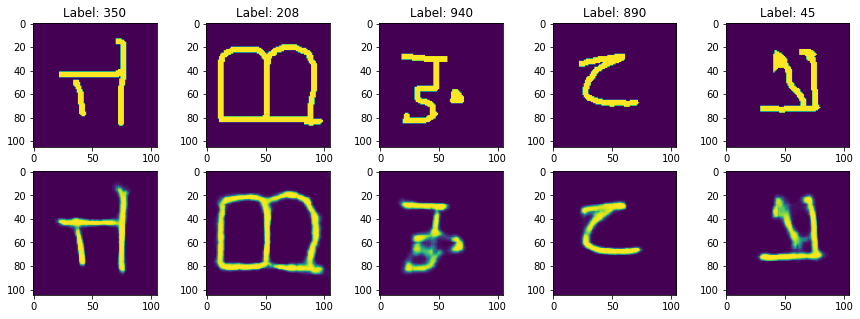

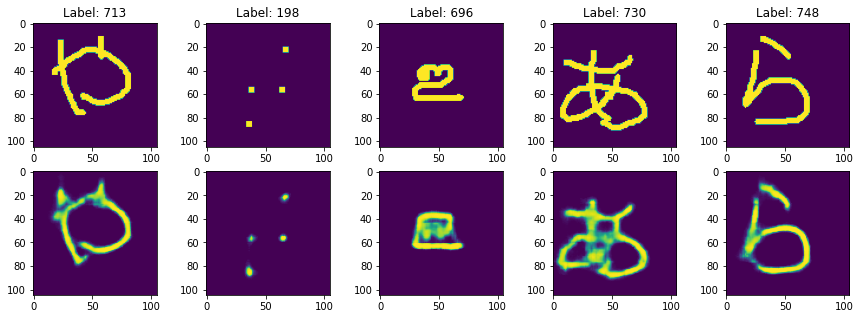

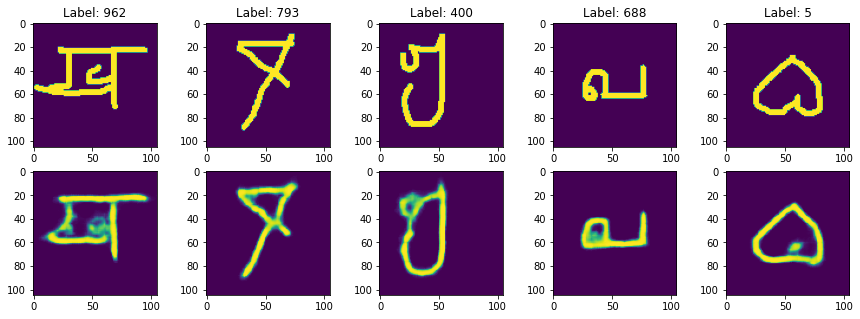

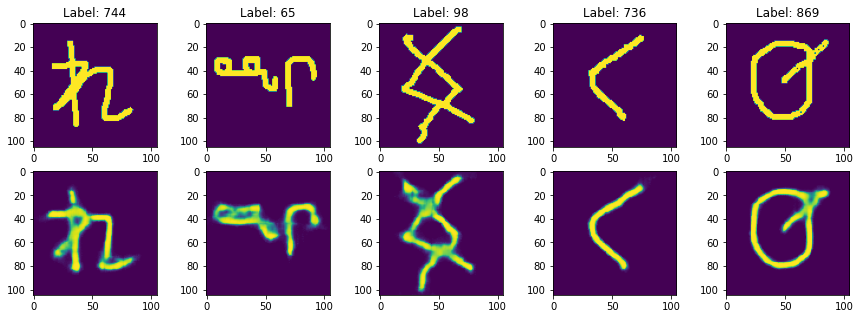

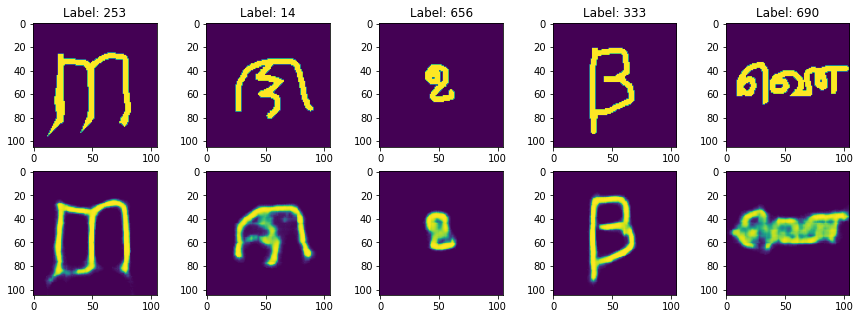

In [ ]:
# Increse epochs for full training
epochs = 20+1

model.to(device)

es = torch.arange(epochs)
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for epoch in tqdm(range(epochs), desc="Epoch"):
    train(epoch, dual_loss, train_loss)
    if epoch % 5 == 0:
        plt.close()
        recon_comp()
        plt.show()
    if epoch % 50 == 0:
        torch.save(model.state_dict(), folder+name)

Text(0.5, 1.0, 'Loss graph over training')

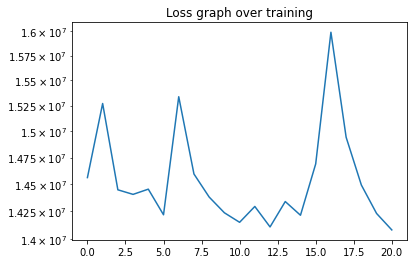

In [ ]:
plt.semilogy(es.cpu(), train_loss.cpu())
plt.title("Loss graph over training")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

Training appears to have stagnated by this point. Roughly 200-300 epochs are needed. Building and training CVAEs was a lot harder than I originally anticapated but keep trying and it eventually works.

In [ ]:
torch.save(model.state_dict(), folder+name)

In [ ]:
train_latent_out = []
test_latent_out = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)

# Dot product average representations to get rough idea of cosine similarity

model.eval()
for batch_idx, (x, label) in enumerate(tqdm(train_loader, desc="Batch")):
    train_latent_out += [torch.einsum("ij->j", model.latent(x.cuda()).data)]
for batch_idx, (x, label) in enumerate(tqdm(test_loader, desc="Batch")):
    test_latent_out += [torch.einsum("ij->j", model.latent(x.cuda()).data)]

train_latent = torch.stack(train_latent_out)
train_latent /= torch.norm(train_latent, dim=0)
conf_matrix_train = torch.einsum("ij,kj->ik", [train_latent, train_latent])

test_latent = torch.stack(test_latent_out)
test_latent /= torch.norm(test_latent, dim=0)
conf_matrix_test = torch.einsum("ij,kj->ik", [test_latent, test_latent])

**Investigating the latent representation**

Caluculating and averaging the the latent representation for each character we can plot a confusion matrix across the dataset. As we can see from the figure below in lighter patches certain alphabets exhibit high similarity.

Text(0.5, 1.0, 'Training set confusion')

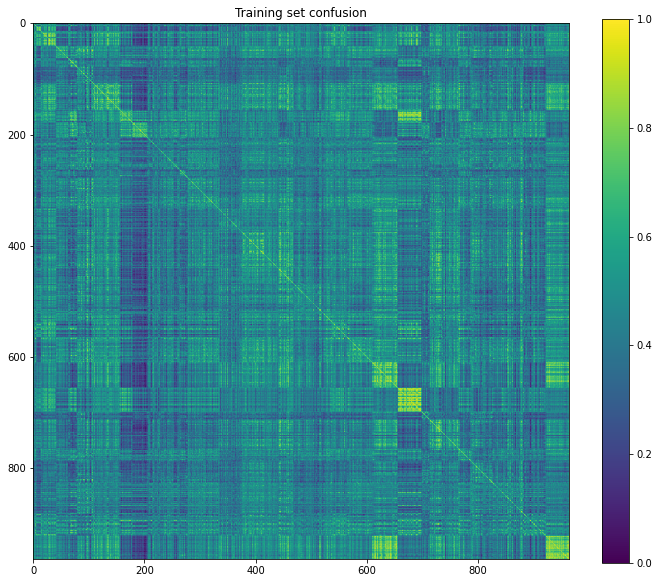

In [ ]:
A = conf_matrix_train
A -= A.min(1, keepdim=True)[0]
A /= A.max(1, keepdim=True)[0]

fig = plt.figure(figsize=[12,10])

plt.imshow(A.cpu().detach())
plt.colorbar()
plt.title("Training set confusion")

The confusion matrix for the test set is noticeably lighter, therefore representing less clarity in execution however a clear charater diagonal remains.

Text(0.5, 1.0, 'Testing set confusion')

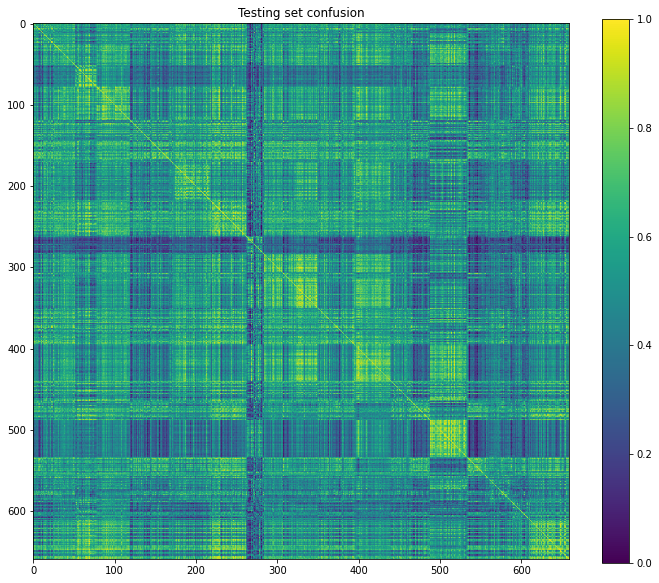

In [ ]:
A = conf_matrix_test
A -= A.min(1, keepdim=True)[0]
A /= A.max(1, keepdim=True)[0]

fig = plt.figure(figsize=[12,10])

plt.imshow(A.cpu().detach())
plt.colorbar()
plt.title("Testing set confusion")

In [ ]:
train_latent_out = []
test_latent_out = []

for batch_idx, (x, label) in enumerate(tqdm(train_loader, desc="Batch")):
    latent = model.latent(x.cuda()).data
    latent /= torch.einsum("i,j->ij", torch.norm(latent, dim=1), torch.norm(latent, dim=0))
    char_conf = torch.einsum("ij,kj->ik", latent, latent)
    char_std = torch.std(char_conf)
    char_avg = torch.norm(char_conf)
    train_latent_out += [[char_avg, char_std]]

for batch_idx, (x, label) in enumerate(tqdm(test_loader, desc="Batch")):
    latent = model.latent(x.cuda()).data
    latent /= torch.einsum("i,j->ij", torch.norm(latent, dim=1), torch.norm(latent, dim=0))
    char_conf = torch.einsum("ij,kj->ik", latent, latent)
    char_std = torch.std(char_conf)
    char_avg = torch.norm(char_conf)
    test_latent_out += [[char_avg, char_std]]

**Cumulative exploration of confidence within character sets**

Analysis of vector similarity within character sets, average and standard deviation plotted. As can be expected the training distribution is slightly skewed to higher certainty than the test distribution.

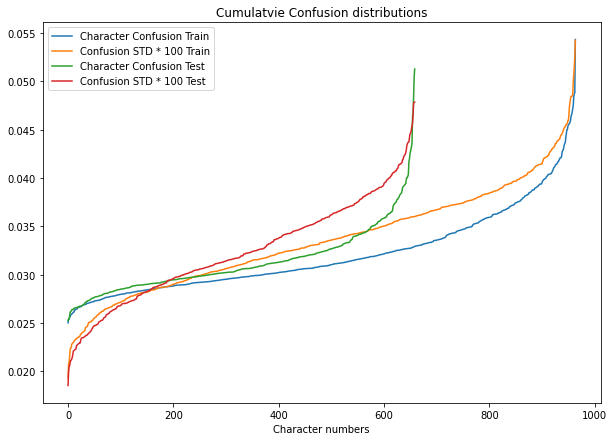

In [ ]:
train_latent_char = torch.stack([torch.stack(l) for l in train_latent_out])
test_latent_char = torch.stack([torch.stack(l) for l in test_latent_out])

sorted_train, _ = torch.sort(train_latent_char, 0)
sorted_test, _ = torch.sort(test_latent_char, 0)

fig = plt.figure(figsize=[10,7])

plt.plot(sorted_train[:,0].cpu().detach(), label='Character Confusion Train')
plt.plot(1e2*sorted_train[:,1].cpu().detach(), label='Confusion STD * 100 Train')

plt.plot(sorted_test[:,0].cpu().detach(), label='Character Confusion Test')
plt.plot(1e2*sorted_test[:,1].cpu().detach(), label='Confusion STD * 100 Test')

plt.title("Cumulatvie Confusion distributions")
plt.xlabel("Character numbers")
plt.legend()

In [ ]:
train_latent_out = []
test_latent_out = []

for batch_idx, (x, label) in enumerate(tqdm(train_loader, desc="Batch")):
    train_latent_out += [model.latent(x.cuda()).data]
for batch_idx, (x, label) in enumerate(tqdm(test_loader, desc="Batch")):
    test_latent_out += [model.latent(x.cuda()).data]

train_latent = torch.stack(train_latent_out)
test_latent = torch.stack(test_latent_out)

In [ ]:
print(train_latent.shape)
print(test_latent.shape)

n = torch.arange(1,20)

train_correct = torch.zeros([20])
train_correct[0] = 1
test_correct = torch.zeros([20])
test_correct[0] = 1

test = 500 # Number of charaters tested per sample size

# Randomly select encoding representaitons from the dataset and compare to charater encodings

for idx, samp in enumerate(n):
    for t in range(test):
        c = random.randint(0,963)
        i1, i2 = random.randint(0,19), random.randint(0,19)
        rc = np.random.randint(0, 963, size=[samp])
        ri = np.random.randint(0, 19, size=[samp])
        target_vec_norm = torch.norm(train_latent[c, i1] - train_latent[c, i2])
        rand_vec_norms = torch.norm(train_latent[c, i1] - train_latent[rc, ri], dim=1)
        if target_vec_norm < rand_vec_norms.min():
            train_correct[samp] += 1

        c = random.randint(0,658)
        i1, i2 = random.randint(0,19), random.randint(0,19)
        rc = np.random.randint(0, 658, size=[samp])
        ri = np.random.randint(0, 19, size=[samp])
        target_vec_norm = torch.norm(test_latent[c, i1] - test_latent[c, i2])
        rand_vec_norms = torch.norm(test_latent[c, i1] - test_latent[rc, ri], dim=1)
        if target_vec_norm < rand_vec_norms.min():
            test_correct[samp] += 1

    train_correct[samp] /= test
    test_correct[samp] /= test
        

torch.Size([964, 20, 64])
torch.Size([659, 20, 64])


**Accuracy comparison**

While the model format is largely unsupervised it still performs much better than a random choice. Additionally the train and test sets perform very similarly indicating the model is not overfitting.

Comparing this to state of the art Siamese Nets suggests significant performace increases are possible and achiving this in a more unsupervised setting may require dataset augmentation with an added cost placed on high representation differences between identical inputs with an affine transformation.

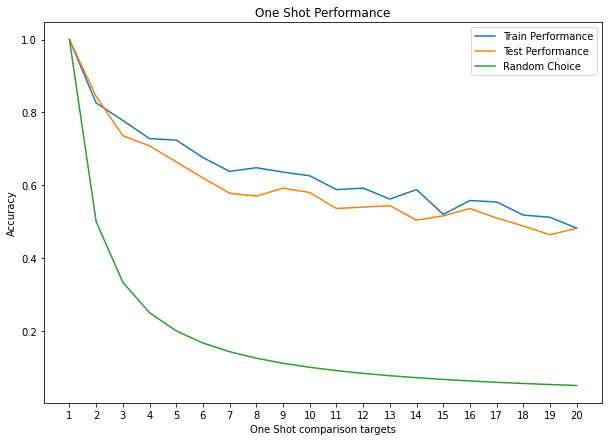

In [ ]:
n = np.arange(1,21)

fig = plt.figure(figsize=[10,7])
plt.plot(n, train_correct.cpu().detach(), label="Train Performance")
plt.plot(n, test_correct.cpu().detach(), label="Test Performance")
plt.plot(n, 1/n, label="Random Choice")
plt.xticks(n)
plt.title("One Shot Performance")
plt.xlabel("One Shot comparison targets")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
print(model)

dual_model(
  (vae): fc_1_vae_model(
    (e): fc_1_encoder(
      (c1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
      (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (c3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (c4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (c51): Conv2d(128, 32, kernel_size=(6, 6), stride=(1, 1))
      (c52): Conv2d(128, 32, kernel_size=(6, 6), stride=(1, 1))
      (act): ReLU()
      (pad): ConstantPad2d(padding=(3, 3, 3, 3), value=0)
    )
    (d): fc_1_decoder(
      (ct1): ConvTranspose2d(32, 128, kernel_size=(6, 6), stride=(1, 1))
      (ct2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (ct3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (ct4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (ct5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2))
      (act): ReLU()
      (unpad): ConstantPad2d(padding=(-3, -3, -3, -3), value=0)
    )
    (r

**Further Work**

* Proper analysis of the role each network plays in training, gradient flow dictated by decoder architecture or labeller architecture.
* Hyperparameter tuning, architecture is very much 'off the shelf'. Possibly look at DenseNet architectures.
* Analysis has lots of redundat code, add additional functions to remove this.
* Analysis of one-shot within alphabets as some alphabets exhibit much more similarity within than across the dataset.
